In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Set torch seed
torch.manual_seed(2023)

In [2]:
# Initialize Hyperparameters
HD_DIMENSION = 15000
NUM_CLASSES = 10
THRESHOLD = 0.0
BATCH_SIZE = 512
IMG_LEN = 28 * 28

In [3]:
# Load data

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

# Initialize HD Memory for classes
hd_memory = torch.zeros((NUM_CLASSES, HD_DIMENSION), device=device)

# Load MNIST Data
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_data = torchvision.datasets.MNIST(root='data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

Using device: mps


In [4]:
# train_data.data.to(device)
# train_data.targets.to(device)
# test_data.data.to(device)
# test_data.targets.to(device)

In [4]:
# Function to generate HD vectors
def generate_hd_vectors(images, proj):

    # Adjust proj to sit between -1 and 1
    proj = (proj * 2) - 1

    # Send images to device
    images = images.to(device)

    # Generate hypervectors and create binary vector
    hd_vectors = torch.sign(images @ proj.T)
    
    return hd_vectors.to(device)

# Classify hd vectors using cosine similarity
def classify_hd_vectors(hd_vectors, hd_memory):
    distances = torch.cdist(hd_vectors, hd_memory, p=2)
    
    # Find the index of the minimum distance
    min_distances, min_indices = torch.min(distances, dim=1)
    return min_indices.to(device)


In [5]:
# Create projection matrix
proj = torch.rand((HD_DIMENSION, IMG_LEN), device=device, dtype=torch.float32)

# Create hyper vectors
hd_vectors = generate_hd_vectors(train_data.data.view(train_data.data.shape[0], -1) / 255, proj)

# Create HD Memory
for i, vec in enumerate(hd_vectors):
    hd_memory[train_data.targets[i]] += vec

hd_memory = torch.sign(hd_memory)

In [6]:
hd_vectors = (hd_vectors == 1).to(torch.float32)
hd_memory = (hd_memory == 1).to(torch.float32)

In [7]:
# Testing training data
classifications = classify_hd_vectors(hd_vectors, hd_memory)

# for i, classification in enumerate(classifications):
#     if classification == train_data.targets[i]:
#         correct += 1
#     total += 1

correct = torch.sum(classifications == train_data.targets.to(device))
total = len(train_data.targets)
print(f"Accuracy on training data: {correct / total * 100}%")

Accuracy on training data: 80.55500030517578%


In [9]:
print(classifications[:20])
print(train_data.targets[:20])

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 2, 3, 6, 1, 7, 2, 8, 6, 1],
       device='mps:0')
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9])


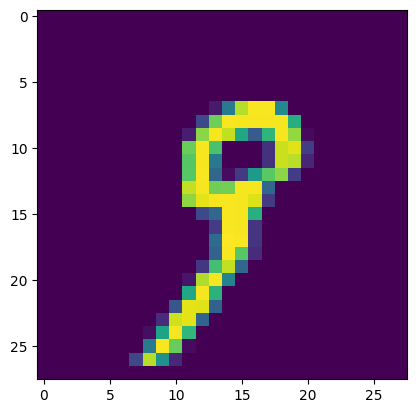

In [10]:
plt.imshow(train_data.data[19].view(28, 28).cpu())

In [11]:
# Testing on test data
hd_vectors_test = generate_hd_vectors(test_data.data.view(test_data.data.shape[0], -1) / 255, proj)
hd_vectors_test = (hd_vectors_test == 1).to(torch.float32)

correct = 0
total = 0

classifications = classify_hd_vectors(hd_vectors_test, hd_memory)

for i, classification in enumerate(classifications):
    if classification == test_data.targets[i]:
        correct += 1
    total += 1

print(f"Accuracy on test data: {correct / total * 100}%")


Accuracy on test data: 81.57%


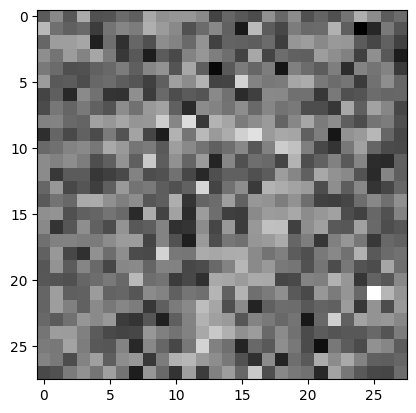

In [12]:
# Compare accuracy when applying random noise to images
noise_level = 0.85

noise_matrix = torch.randn((test_data.data.shape[0], IMG_LEN), device=device) * noise_level

# Plot noise matrix
noisy_test_data = (test_data.data.view(test_data.data.shape[0], -1) / 255).to(device) + noise_matrix

plt.imshow(noisy_test_data[0].view(28, 28).cpu(), cmap='gray')

hd_vectors_noise = generate_hd_vectors(noisy_test_data, proj)
hd_vectors_noise = (hd_vectors_noise == 1).to(torch.float32)
    

In [13]:
# Test noisy test data

classifications = classify_hd_vectors(hd_vectors_noise, hd_memory)

correct = torch.sum(classifications == test_data.targets.to(device))
total = len(test_data.targets)
print(f"Accuracy on test data with noise: {correct / total * 100}%")

Accuracy on test data with noise: 70.9000015258789%


In [14]:
# Create simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(IMG_LEN, 512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, NUM_CLASSES)
    
    def forward(self, x):
        x = x.view(-1, IMG_LEN)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    
# Create neural network
model = NeuralNetwork().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train neural network
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (BATCH_SIZE, 28*28)
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss and accuracy after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.4091
Accuracy: 93.20%
Epoch [2/10], Loss: 0.1643
Accuracy: 95.69%
Epoch [3/10], Loss: 0.0915
Accuracy: 97.02%
Epoch [4/10], Loss: 0.0605
Accuracy: 97.81%
Epoch [5/10], Loss: 0.0179
Accuracy: 98.14%
Epoch [6/10], Loss: 0.0755
Accuracy: 98.59%
Epoch [7/10], Loss: 0.1688
Accuracy: 98.91%
Epoch [8/10], Loss: 0.0366
Accuracy: 99.15%
Epoch [9/10], Loss: 0.0144
Accuracy: 99.19%
Epoch [10/10], Loss: 0.0352
Accuracy: 99.17%


In [15]:
# Testing loop to evaluate the model using test_loader
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.99%


In [32]:
# Test noisy test data with varying noise levels
noise_levels = np.arange(0, 1, 0.02)
total = len(test_data.targets)
accuracies_hd = []

for noise_level in noise_levels:
    noise_matrix = torch.randn((test_data.data.shape[0], IMG_LEN), device=device) * noise_level

    # Plot noise matrix
    noisy_test_data = (test_data.data.view(test_data.data.shape[0], -1) / 255).to(device) + noise_matrix

    hd_vectors_noise = generate_hd_vectors(noisy_test_data, proj)
    hd_vectors_noise = (hd_vectors_noise == 1).to(torch.float32)

    classifications = classify_hd_vectors(hd_vectors_noise, hd_memory)

    correct = torch.sum(classifications.cpu() == test_data.targets)

    accuracies_hd.append(correct / total * 100)


In [33]:
# Test neural network with progressively more noise
accuracies_net = []

for noise_level in noise_levels:

    # Test noisy test data
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)

            # Add noise to images
            noise_matrix = torch.randn((images.shape[0], IMG_LEN), device=device) * noise_level
            images = images + noise_matrix

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracies_net.append(correct / total * 100)



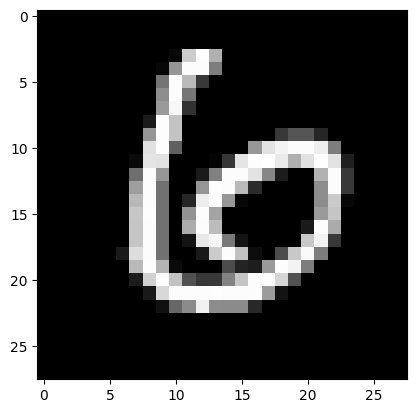

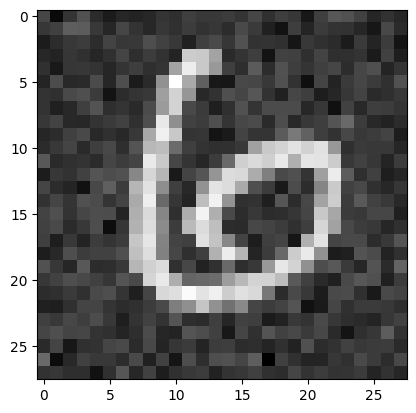

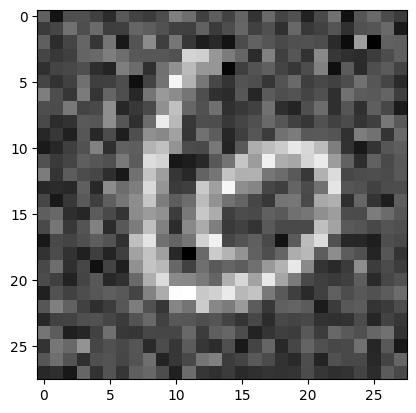

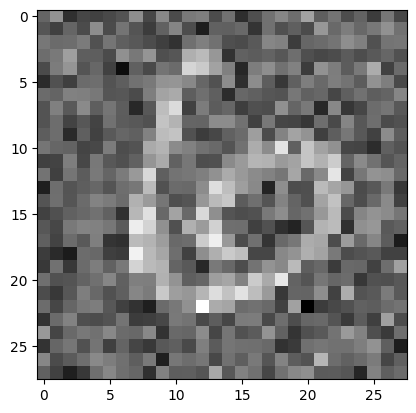

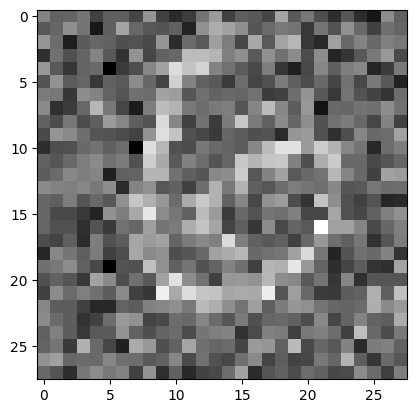

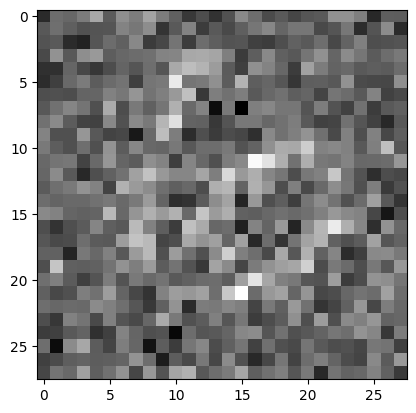

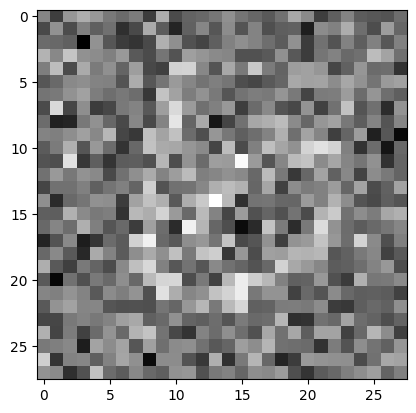

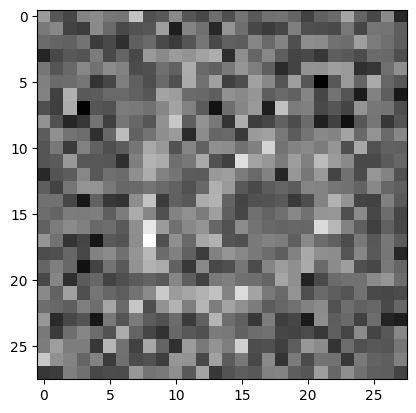

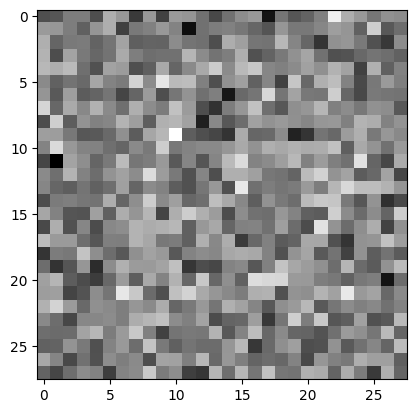

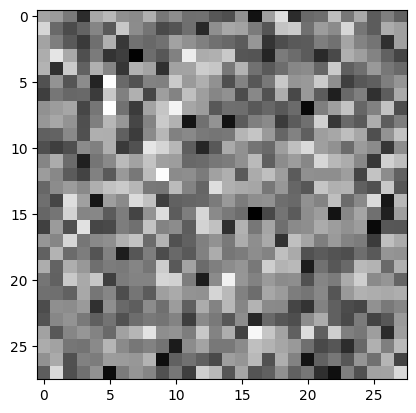

In [57]:
# Plot a random image from the test set with the various noise levels
index = 11
for noise_level in np.arange(0, 1, 0.1):
    noise_matrix = torch.randn((test_data.data.shape[0], IMG_LEN), device=device) * noise_level

    # Plot noise matrix
    noisy_test_data = (test_data.data.view(test_data.data.shape[0], -1) / 255).to(device) + noise_matrix

    plt.imshow(noisy_test_data[index].view(28, 28).cpu(), cmap='gray')
    plt.show()

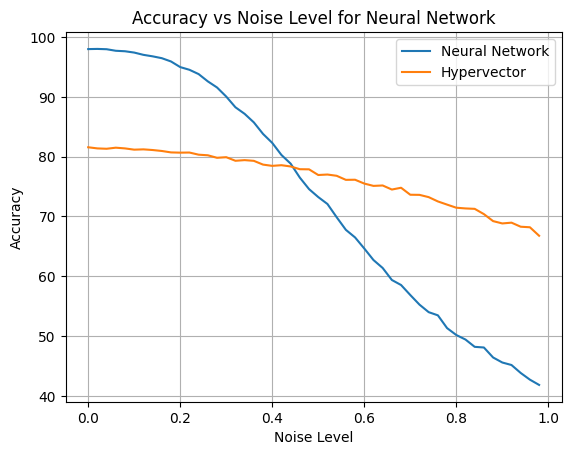

In [58]:
plt.plot(noise_levels, accuracies_net)
plt.plot(noise_levels, accuracies_hd)
plt.legend(["Neural Network", "Hypervector"])
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Noise Level for Neural Network")
plt.grid()